# Classification of Normal and Acute Myeloid Leukemia (AML) with RUNX1-RUNX1T1 Fusion Gene

## Introduction

Acute myeloid leukemia (AML) with t(8;21)(q22;q22.1);RUNX1-RUNX1T1, one of the core-binding factor leukemias, is one of the most common subtypes of AML with recurrent genetic abnormalities and is associated with a favorable outcome. This translocation leads to the formation of a pathological RUNX1-RUNX1T1 fusion protein, disrupting the normal function of the core-binding factor, which plays a crucial role in hematopoietic differentiation and maturation. This chromosomal rearrangement is one of the most common, with an incidence of 15% in children and young adults.

For our study, we obtained images of peripheral blood smears from both normal (control) and leukemia patients with RUNX1-RUNX1T1 Fusion Gene (RUNX1_RUNX1T1) from the Cancer Image Archive. Images of patients from each group were pooled; these were then used to train our CNN model. The model achieved F1 scores of ~0.9 for both normal cells and leukemia cells.

[1] https://www.cancerimagingarchive.net/collection/aml-cytomorphology_mll_helmholtz/

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import random
random.seed(42)

In [2]:
import tensorflow as tf

C:\Users\kaizi\anaconda3\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
print(tf.__version__)

2.10.1


## File Exploration

In [4]:
dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\aml_data\\'

In [5]:
def find_control_and_count_files(root_directory, target):
    control_path = None
    
    # Traverse the directory hierarchy to find the 'control' folder
    for root, dirs, files in os.walk(root_directory):
        if target in dirs:
            control_path = os.path.join(root, target)
            break
    
    if not control_path:
        print(f'No {target} folder found.')
        return
    
    total_files = 0
    
    # Count files in target folder and all its subdirectories
    for root, dirs, files in os.walk(control_path):
        total_files += len(files)
    
    print(f"Total number of files under the {target} folder: {total_files}")

In [6]:
classes = ['control', 'RUNX1_RUNX1T1']

In [7]:
for item in classes:
    find_control_and_count_files(dir, item)

Total number of files under the control folder: 20305
Total number of files under the RUNX1_RUNX1T1 folder: 14403


## Generate Train, Validate, Test Dataset

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [9]:
# Initialize the lists to store the images and labels
images = []
labels = []

# Desired dimensions
target_height = 144
target_width = 144

# use subset of images
image_batch_size = 4000

# Loop through each class folder, randomly select 1500 images for each class
for class_ in classes:
    class_path = os.path.join(dir, class_)
    
    # Get the list of images in the current class folder and its subdirectories
    image_paths = []
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.endswith('.tif'):
                image_paths.append(os.path.join(root, file))

    # Shuffle and select images
    random.shuffle(image_paths)
    selected_image_paths = image_paths[:image_batch_size]

    # Loop through each selected image
    for image_path in selected_image_paths:
        # Read the image using PIL
        with Image.open(image_path) as img:
            # Convert the image to RGB
            img = img.convert('RGB')
            # Resize the image to the target dimensions
            img = img.resize((target_width, target_height))
            # Convert the image to a numpy array
            image_array = np.array(img)
            # Normalize the image
            image_array = image_array / 255.0
        
            # Add the image and label to the lists
            images.append(image_array)
            labels.append(classes.index(class_))  # Use the index of the class as the label

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {train_images.shape}')
print(f'Testing images shape: {test_images.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Testing labels shape: {test_labels.shape}')

Training images shape: (6400, 144, 144, 3)
Testing images shape: (1600, 144, 144, 3)
Training labels shape: (6400,)
Testing labels shape: (1600,)


In [10]:
# split off 15% of training set as validation set
validation_images, remaining_images, validation_labels, remaining_labels = train_test_split(
    train_images, train_labels, test_size=0.85, random_state=42, stratify=train_labels
)

# Update the training data to be the remaining images and labels
train_images = remaining_images
train_labels = remaining_labels

In [11]:
print(f'Training images shape: {train_images.shape}')
print(f'Validation images shape: {validation_images.shape}')
print(f'Testing images shape: {test_images.shape}')

Training images shape: (5440, 144, 144, 3)
Validation images shape: (960, 144, 144, 3)
Testing images shape: (1600, 144, 144, 3)


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validate_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [13]:
# Batch and shuffle the datasets
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

In [14]:
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validate_dataset = validate_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
def plot_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()

### Ploting Images from Train Data Set

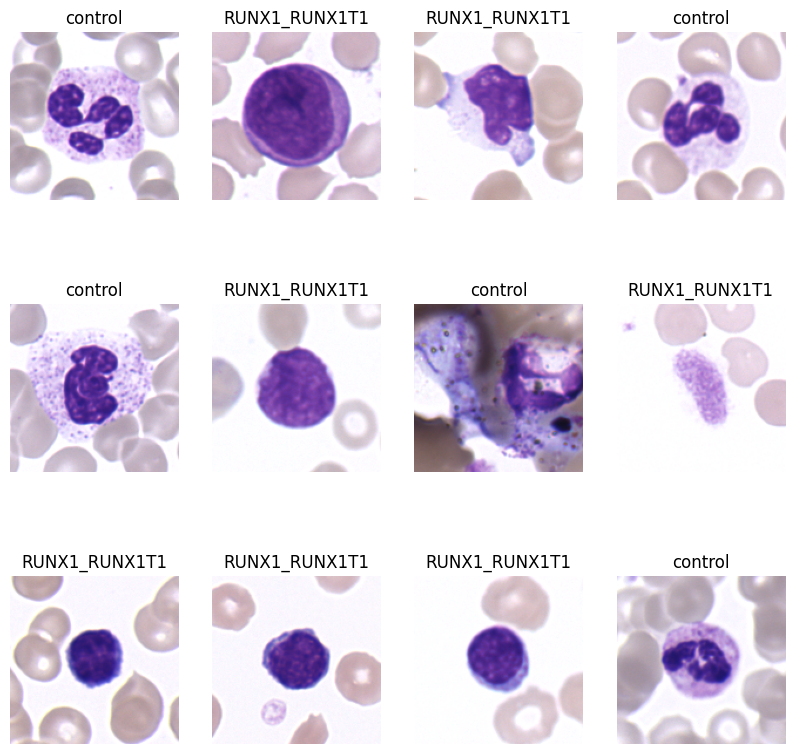

In [16]:
plot_images(train_dataset, classes)

### Plotting images from Test Data Set

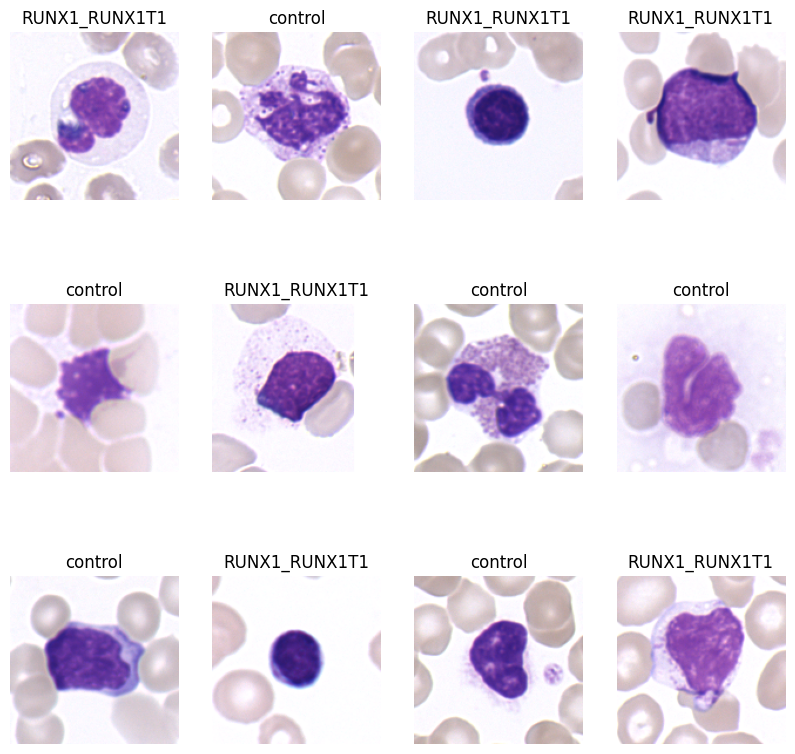

In [17]:
plot_images(test_dataset, classes)

## Training: Hyper-parameter Tunning

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [19]:
# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(144, 144, 3)))
    
    # Tune the number of units in the first Conv2D layer
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(layers.Conv2D(hp_units, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Add more Conv2D layers with batch normalization
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Conv2D(hp.Int(f'conv_{i}_units', 64, 256, step=64), (3, 3), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [20]:
dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\PKG_AML'

In [21]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=dir,
                     project_name='model_tunning_files')

In [22]:
# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [23]:
# Search for the best hyperparameters
tuner.search(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[stop_early])

Trial 30 Complete [00h 03m 04s]
val_accuracy: 0.8999999761581421

Best val_accuracy So Far: 0.9231250286102295
Total elapsed time: 00h 30m 17s


In [24]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

### Print the Optimal Hyperparameters

In [25]:
print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units')}.
The optimal number of layers is {best_hps.get('num_layers')}.
The optimal number of neuron in the first layer is {best_hps.get('conv_1_units')}.
The optimal number of neuron is the second layer is {best_hps.get('conv_2_units')}.
The optimal number of neuron is the third layer is {best_hps.get('conv_2_units')}.
The optimal units in the last dense layer is {best_hps.get('dense_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the first dense layer is 64.
The optimal number of layers is 2.
The optimal number of neuron in the first layer is 256.
The optimal number of neuron is the second layer is 192.
The optimal number of neuron is the third layer is 192.
The optimal units in the last dense layer is 256.
The optimal learning rate for the optimizer is 1e-05.



In [26]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

### Model Summary

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 142, 142, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 142, 142, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 71, 71, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 69, 69, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 69, 69, 128)      512       
 hNormalization)                                                 
                                                      

In [28]:
history = model.fit(train_dataset, epochs=50, validation_data=validate_dataset, callbacks=[stop_early])

Epoch 1/50
340/340 [==============================] - 15s 43ms/step - loss: 0.3769 - accuracy: 0.8414 - val_loss: 1.2659 - val_accuracy: 0.5052
Epoch 2/50
340/340 [==============================] - 18s 53ms/step - loss: 0.1543 - accuracy: 0.9436 - val_loss: 0.2872 - val_accuracy: 0.8885
Epoch 3/50
340/340 [==============================] - 19s 56ms/step - loss: 0.0820 - accuracy: 0.9761 - val_loss: 0.2743 - val_accuracy: 0.8938
Epoch 4/50
340/340 [==============================] - 19s 56ms/step - loss: 0.0442 - accuracy: 0.9897 - val_loss: 0.2841 - val_accuracy: 0.9000
Epoch 5/50
340/340 [==============================] - 19s 56ms/step - loss: 0.0248 - accuracy: 0.9969 - val_loss: 0.3475 - val_accuracy: 0.8896
Epoch 6/50
340/340 [==============================] - 15s 43ms/step - loss: 0.0192 - accuracy: 0.9971 - val_loss: 0.2827 - val_accuracy: 0.9031


In [29]:
def show_loss_accuracy(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plotting the loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the accuracy
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

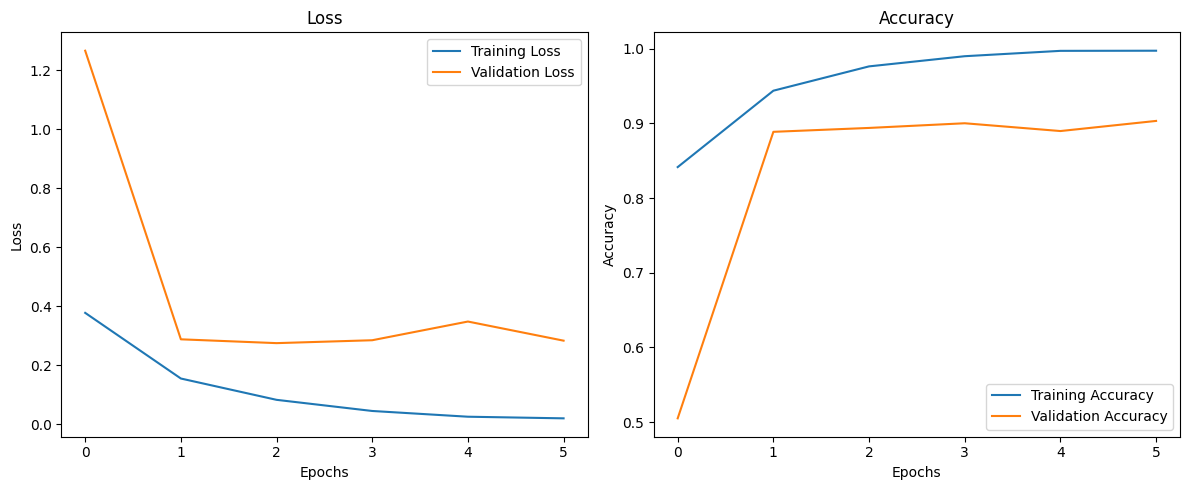

In [30]:
show_loss_accuracy(history)

## Validating model using Test Data

In [31]:
# loss, accuracy against the test_datset
results = model.evaluate(test_dataset)
print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")

100/100 [==============================] - 1s 11ms/step - loss: 0.2323 - accuracy: 0.9100
Loss: 0.23226948082447052
Accuracy: 0.9100000262260437


In [32]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

def show_predictions(model):
    #Extract labels from the test dataset
    test_labels = []
    for _, labels in test_dataset:
        test_labels.extend(labels.numpy())
    
    pred_proba = model.predict(test_dataset)
    
    # ConfusionMatrixDisplay.from_predictions(test_labels, predictions, normalize="true", values_format=".0%")
    predictions = (pred_proba > 0.5).astype(int).flatten()

    # Generate classification report
    print(classification_report(test_labels, predictions, target_names=classes))

    cm = confusion_matrix(test_labels, predictions)
    cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".0%") 
    plt.title('Confusion Matrix')
    plt.show()

100/100 [==============================] - 1s 9ms/step
               precision    recall  f1-score   support

      control       0.94      0.88      0.91       800
RUNX1_RUNX1T1       0.89      0.94      0.91       800

     accuracy                           0.91      1600
    macro avg       0.91      0.91      0.91      1600
 weighted avg       0.91      0.91      0.91      1600



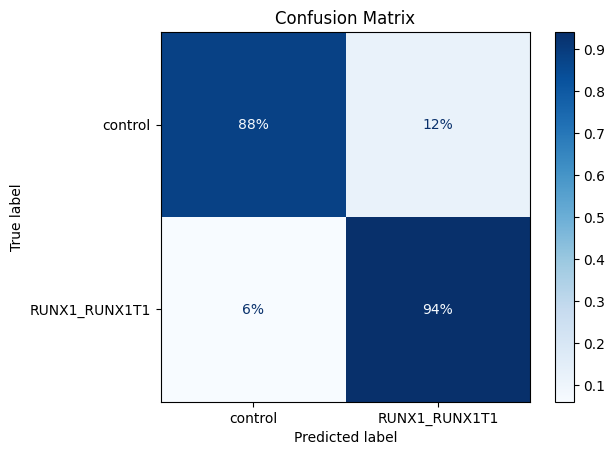

In [33]:
show_predictions(model)

## Conclusion and Discussion

In this study, we developed an innovative convolutional neural network (CNN) model to distinguish between normal cells and acute myeloid leukemia (AML) cells with the RUNX1-RUNX1T1 fusion gene. Our model achieved impressive F1 scores of 0.91 for both normal and leukemia cells. On our test dataset, the model demonstrated a true positive rate exceeding 88% for normal cells, with 12% misclassified as leukemia cells. For leukemia patients, 6% of blood cells were inaccurately predicted as normal. These misclassifications may partly be due to the presence of normal blood cells in the leukemia dataset, as it is common for leukemia patients to have some normal cells.

To improve accuracy, it may be beneficial to curate the dataset more meticulously and retrain the model. Additionally, due to the limitations of local GPU usage, it was not possible to train the model using all the images in the dataset. Despite these constraints, our model lays a foundation for transfer learning in the classification of other human leukemias.
